<a href="https://colab.research.google.com/github/dinaldoap/jit-sdp-nn/blob/master/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/dinaldoap/jit-sdp-data/master/jenkins.csv')
df.head()

,fix,ns,nd,nf,entropy,la,ld,lt,ndev,age,nuc,exp,rexp,sexp,author_date_unix_timestamp,classification,contains_bug
0,False,7.0,7.0,7.0,2.641604,9.0,9.0,426.428571,100.0,0.000093,1.0,5171.0,30.227271,1472.714286,1555326371,None,False
1,False,7.0,7.0,7.0,2.750000,8.0,8.0,426.428571,100.0,6.314775,2.0,5170.0,29.227271,1471.714286,1555326363,None,False
2,False,1.0,1.0,2.0,0.906580,15.0,44.0,96.000000,4.0,0.034722,2.0,629.0,14.828373,414.000000,1554971763,None,False
3,False,1.0,1.0,1.0,0.000000,0.0,0.0,40.000000,1.0,0.000012,1.0,4.0,3.058824,3.000000,1554969774,None,False
4,False,1.0,2.0,4.0,1.662506,14.0,10.0,67.000000,6.0,21.280683,4.0,3.0,2.058824,2.000000,1554967752,Feature Addition,False


In [3]:
#df = df.sample(n=5000)
df = df.sort_index(axis='index')
label_col = 'contains_bug'
features_cols = ['fix', 'ns', 'nd', 'nf', 'entropy', 'la', 'ld', 'lt', 'ndev', 'age', 'nuc', 'exp', 'rexp', 'sexp', 'classification']
x = df[features_cols]
x['fix'] = x['fix'].astype('int')
df_classification = pd.get_dummies(x, columns=['classification'])
x = pd.concat([x, df_classification], axis='columns')
x = x.drop(['classification'], axis='columns')
y = df[label_col]
y = y.astype('category')
y = y.cat.codes
y = y.rename('y')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
print(x.head())
print(y.head())

   fix   ns  ...  classification_Perfective  classification_Preventative
0    0  7.0  ...                          0                            0
1    0  7.0  ...                          0                            0
2    0  1.0  ...                          0                            0
3    0  1.0  ...                          0                            0
4    0  1.0  ...                          0                            0

[5 rows x 34 columns]
0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int8


In [0]:
pca = PCA(n_components=2)
pts = pca.fit_transform(x)
pts = pd.DataFrame(pts, index=df.index,  columns=['x1', 'x2'])
pts = pts.reset_index()
pts = pts.rename(columns={'index': 'timestep'})
pts = pd.concat([pts, y], axis='columns')

In [6]:
pts[:3]

,timestep,x1,x2,y
0,0,4580.002970,-273.337549,0
1,1,4577.929242,-273.590210,0
2,2,-1694.743694,-895.349280,0


In [7]:
for col in ['x1', 'x2']:
  q_min, q_max = pts[col].quantile([0.01, 0.99])
  print('({}, {})'.format(q_min, q_max))
  pts = pts[pts[col] <= q_max]
  pts = pts[pts[col] >= q_min]

(-2809.376122670254, 9216.26601446471)
(-1060.603162586104, 6448.379275517251)


In [0]:
def plot_drift(data):
  n_bins = 6
  bin_size = len(df) // n_bins
  fig, ax = plt.subplots(nrows=n_bins, figsize=(18, 36), sharex=True, sharey=True, constrained_layout=True)
  for bin in range(n_bins):
    palette = 'coolwarm' if bin % 2 == 0 else 'coolwarm_r'
    bin_data = data[data['timestep'] >= bin*bin_size]
    bin_data = bin_data[bin_data['timestep'] <= (bin+1)*bin_size]    
    sns.scatterplot(x="x1", y="x2", hue='timestep', palette=palette, data=bin_data, ax=ax[bin])
  fig.show()

def normal(data):
  return data[data['y'] == 0]

def bug(data):
  return data[data['y'] == 1]

def plot_drifts(data):
  n_bins = 6
  bin_size = len(df) // n_bins
  fig, ax = plt.subplots(nrows=n_bins, ncols=2, figsize=(22, 36), sharex=True, sharey=True, constrained_layout=True)
  for bin in range(n_bins):
    palette = 'coolwarm' if bin % 2 == 0 else 'coolwarm_r'
    bin_data = data[data['timestep'] >= bin*bin_size]
    bin_data = bin_data[bin_data['timestep'] <= (bin+1)*bin_size]    
    sns.scatterplot(x="x1", y="x2", hue='timestep', palette=palette, data=normal(bin_data), ax=ax[bin, 0])
    sns.scatterplot(x="x1", y="x2", hue='timestep', palette=palette, data=bug(bin_data), ax=ax[bin, 1])
  fig.show()

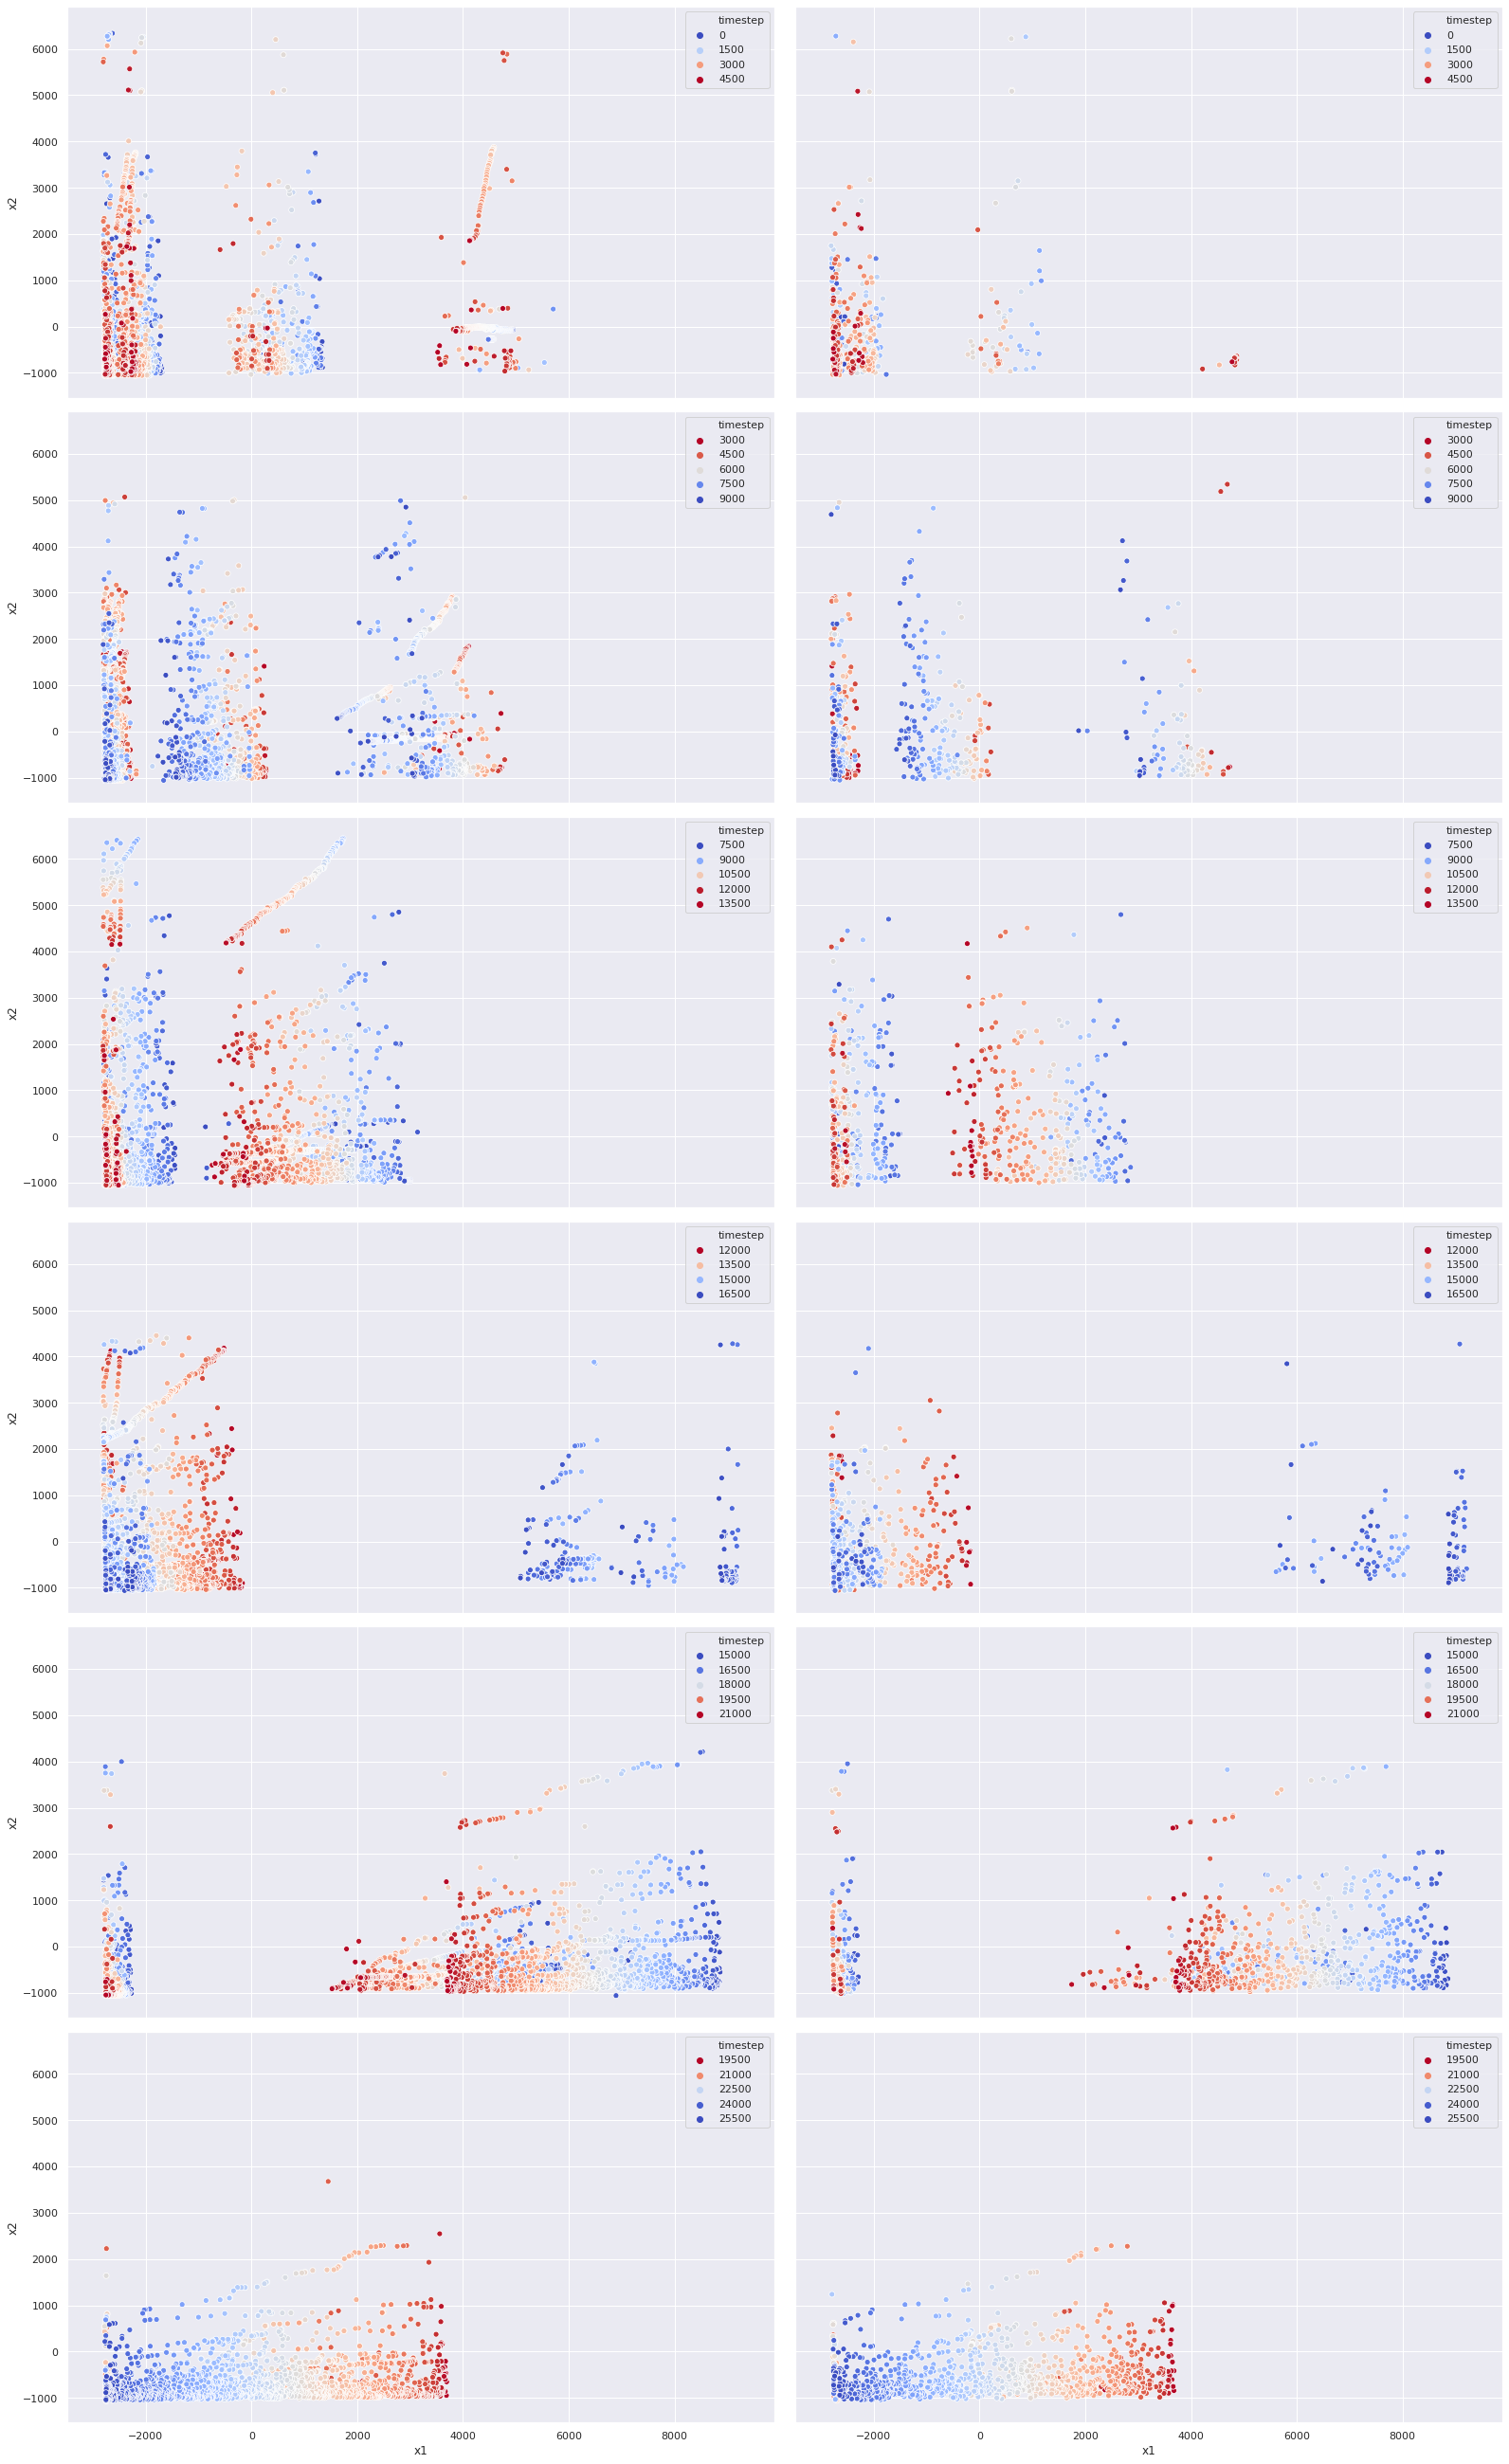

In [9]:
plot_drifts(pts)

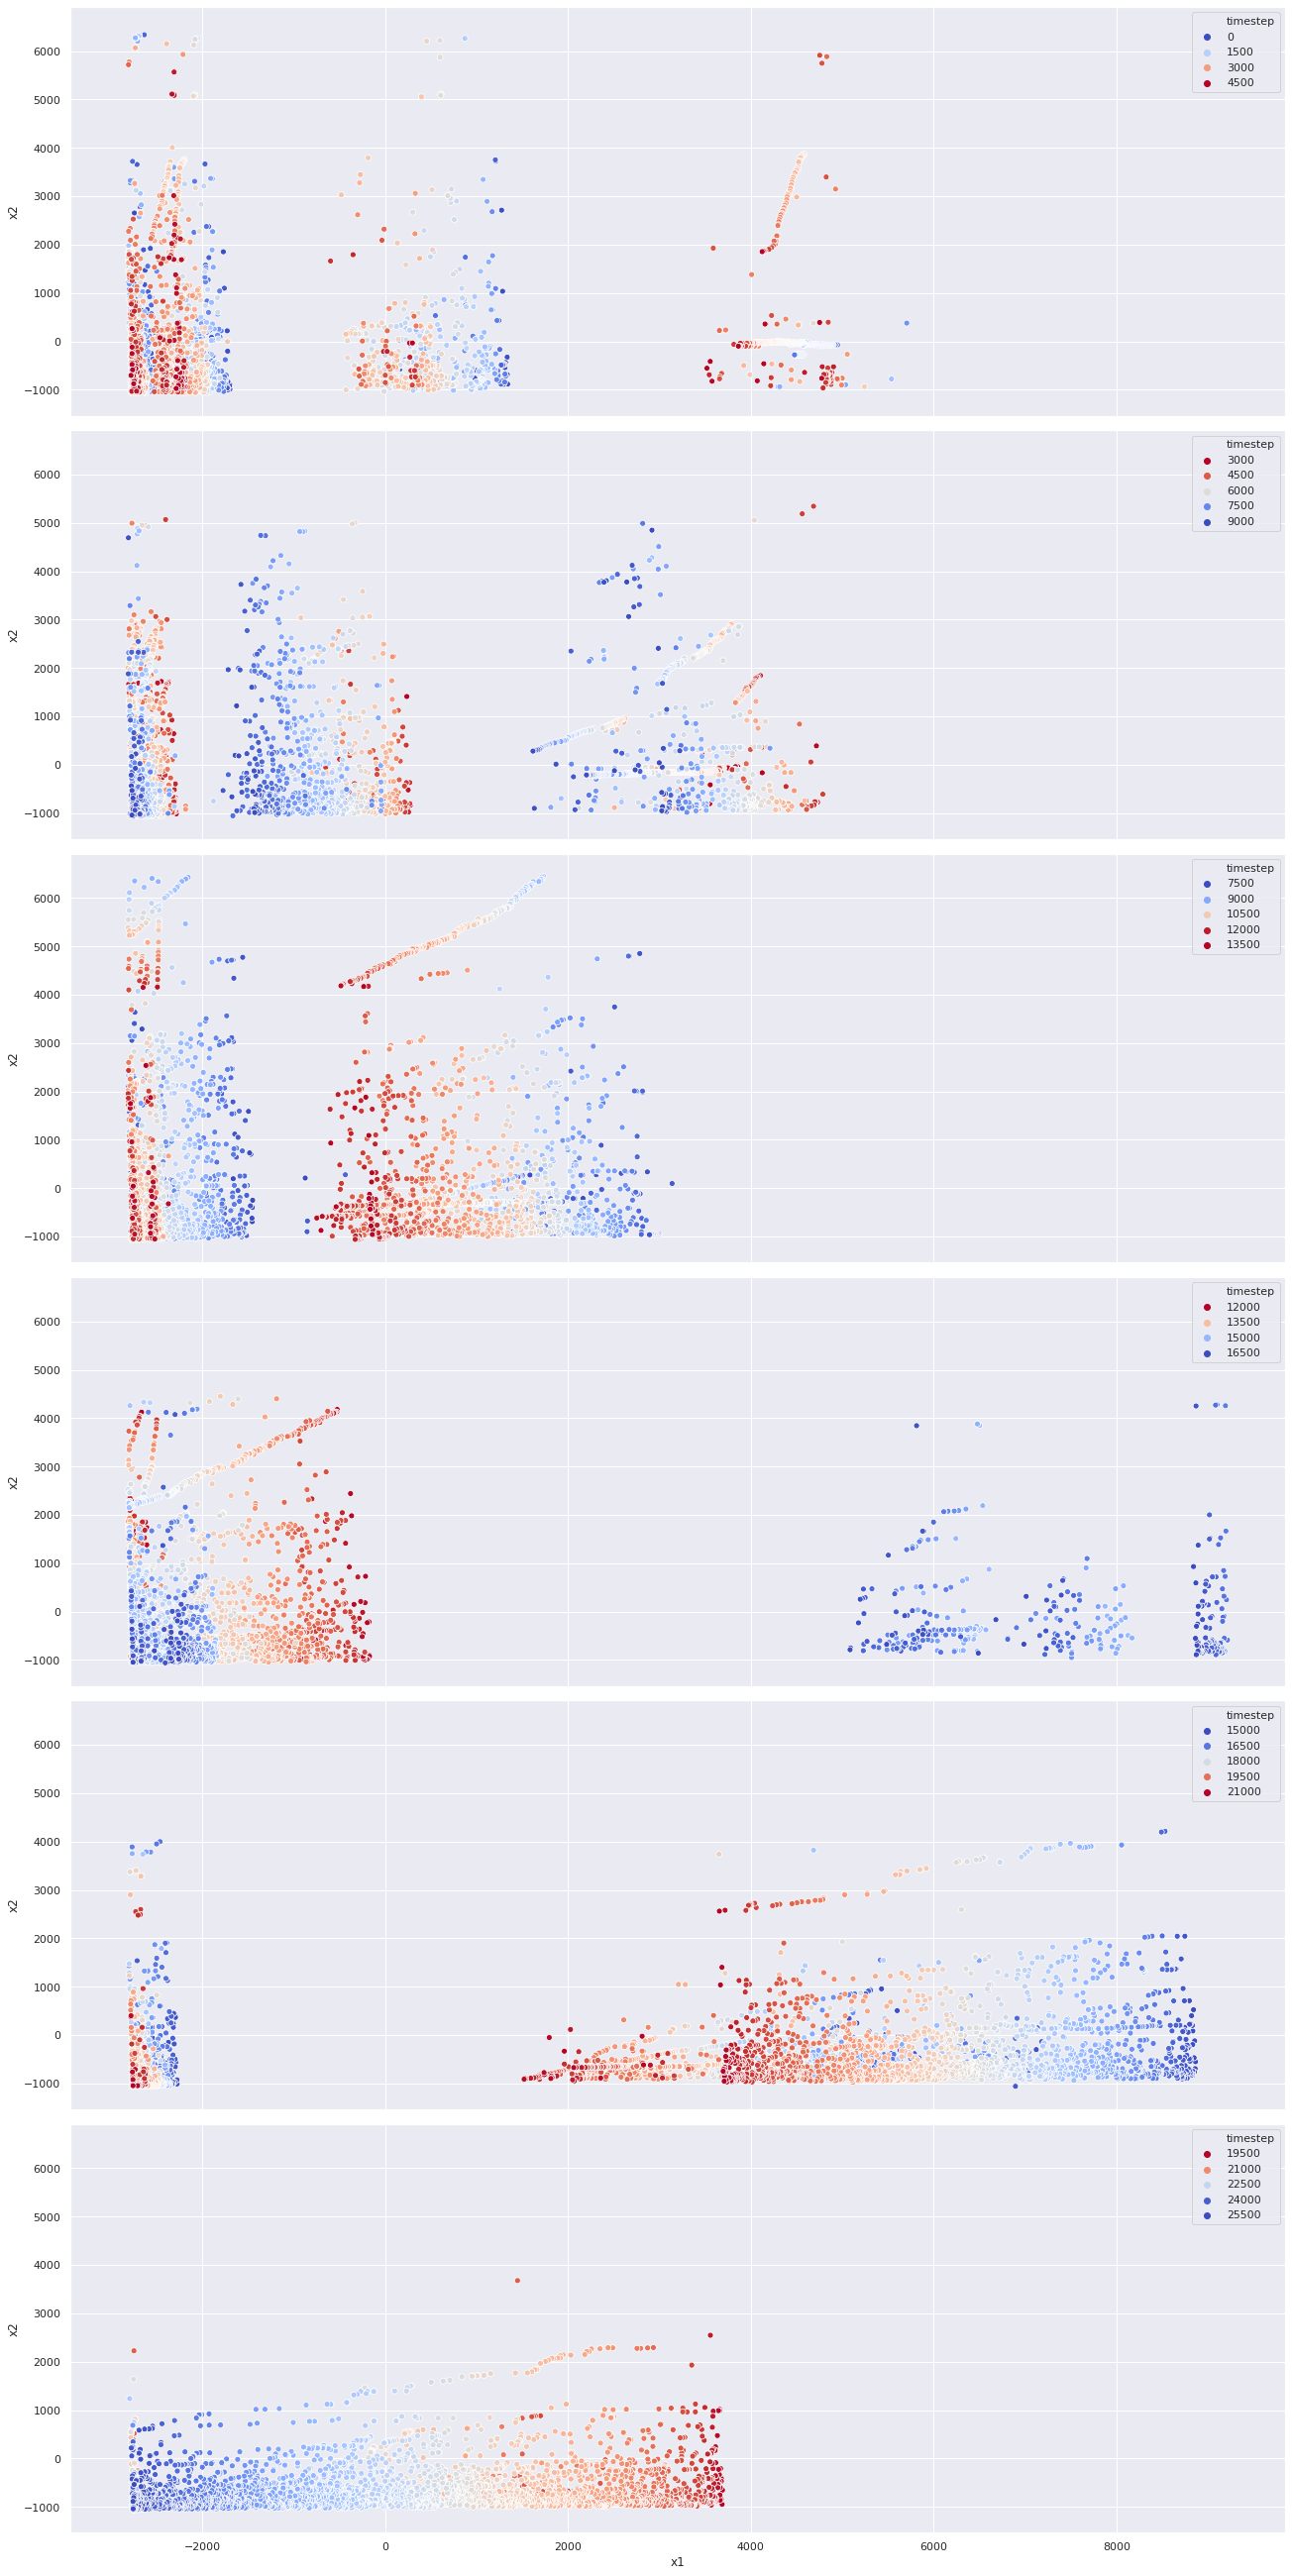

In [10]:
plot_drift(pts)

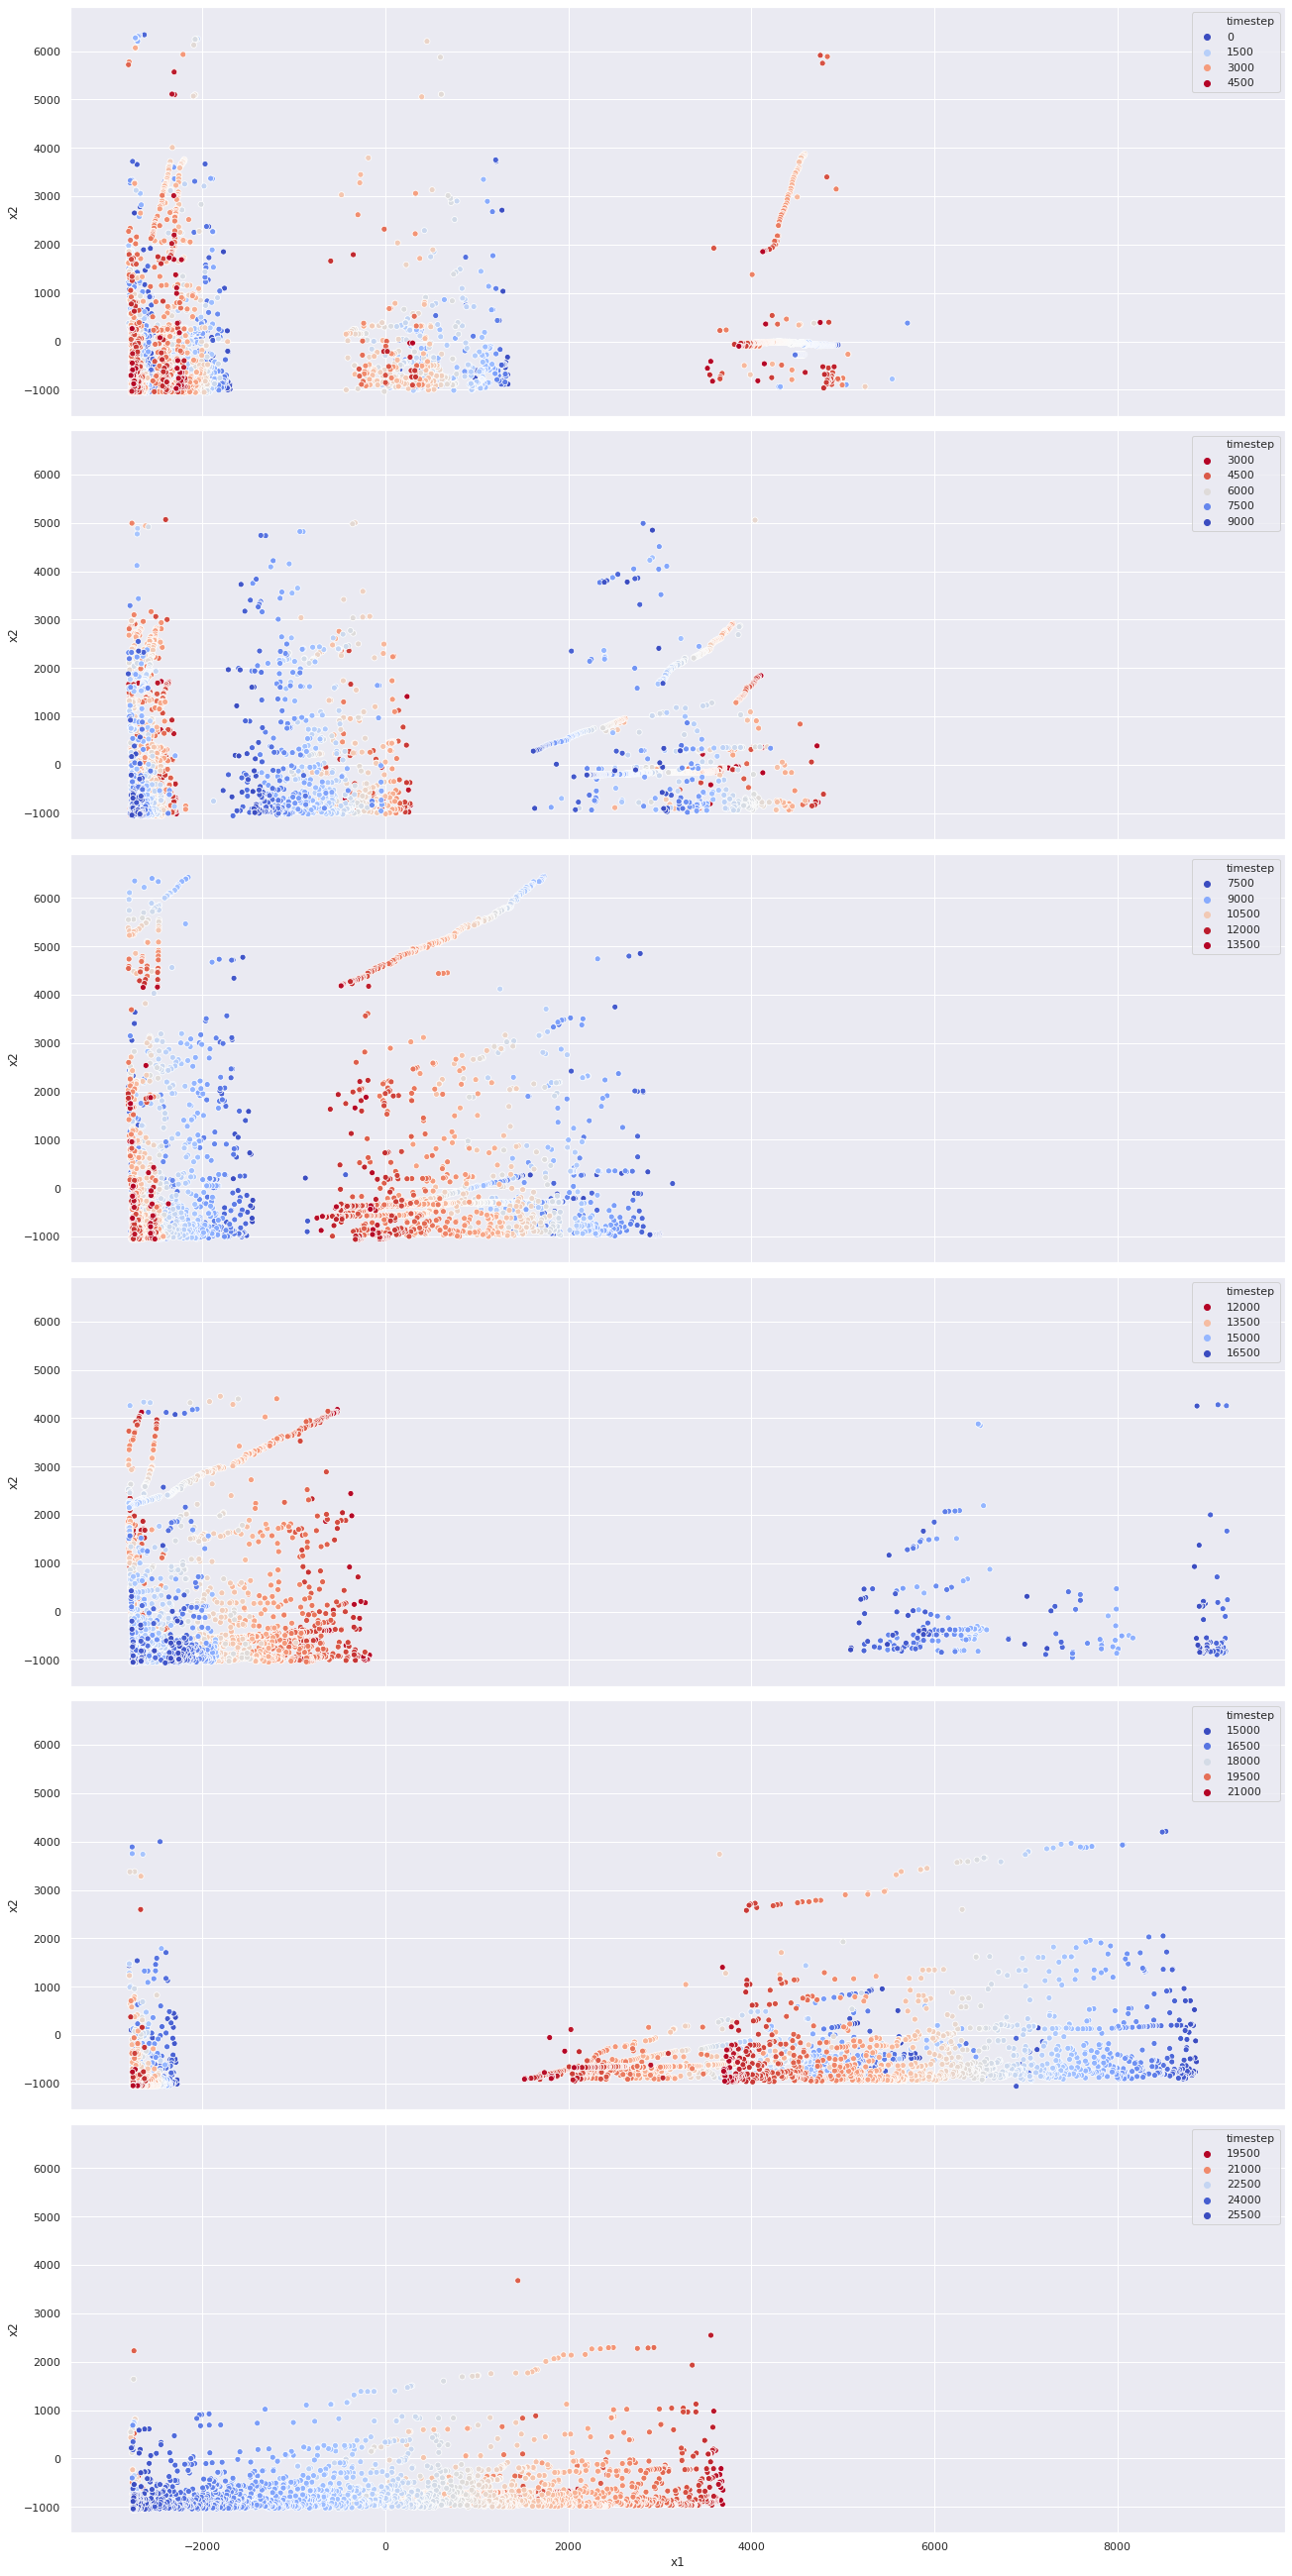

In [11]:
pts_normal = normal(pts)
plot_drift(pts_normal)

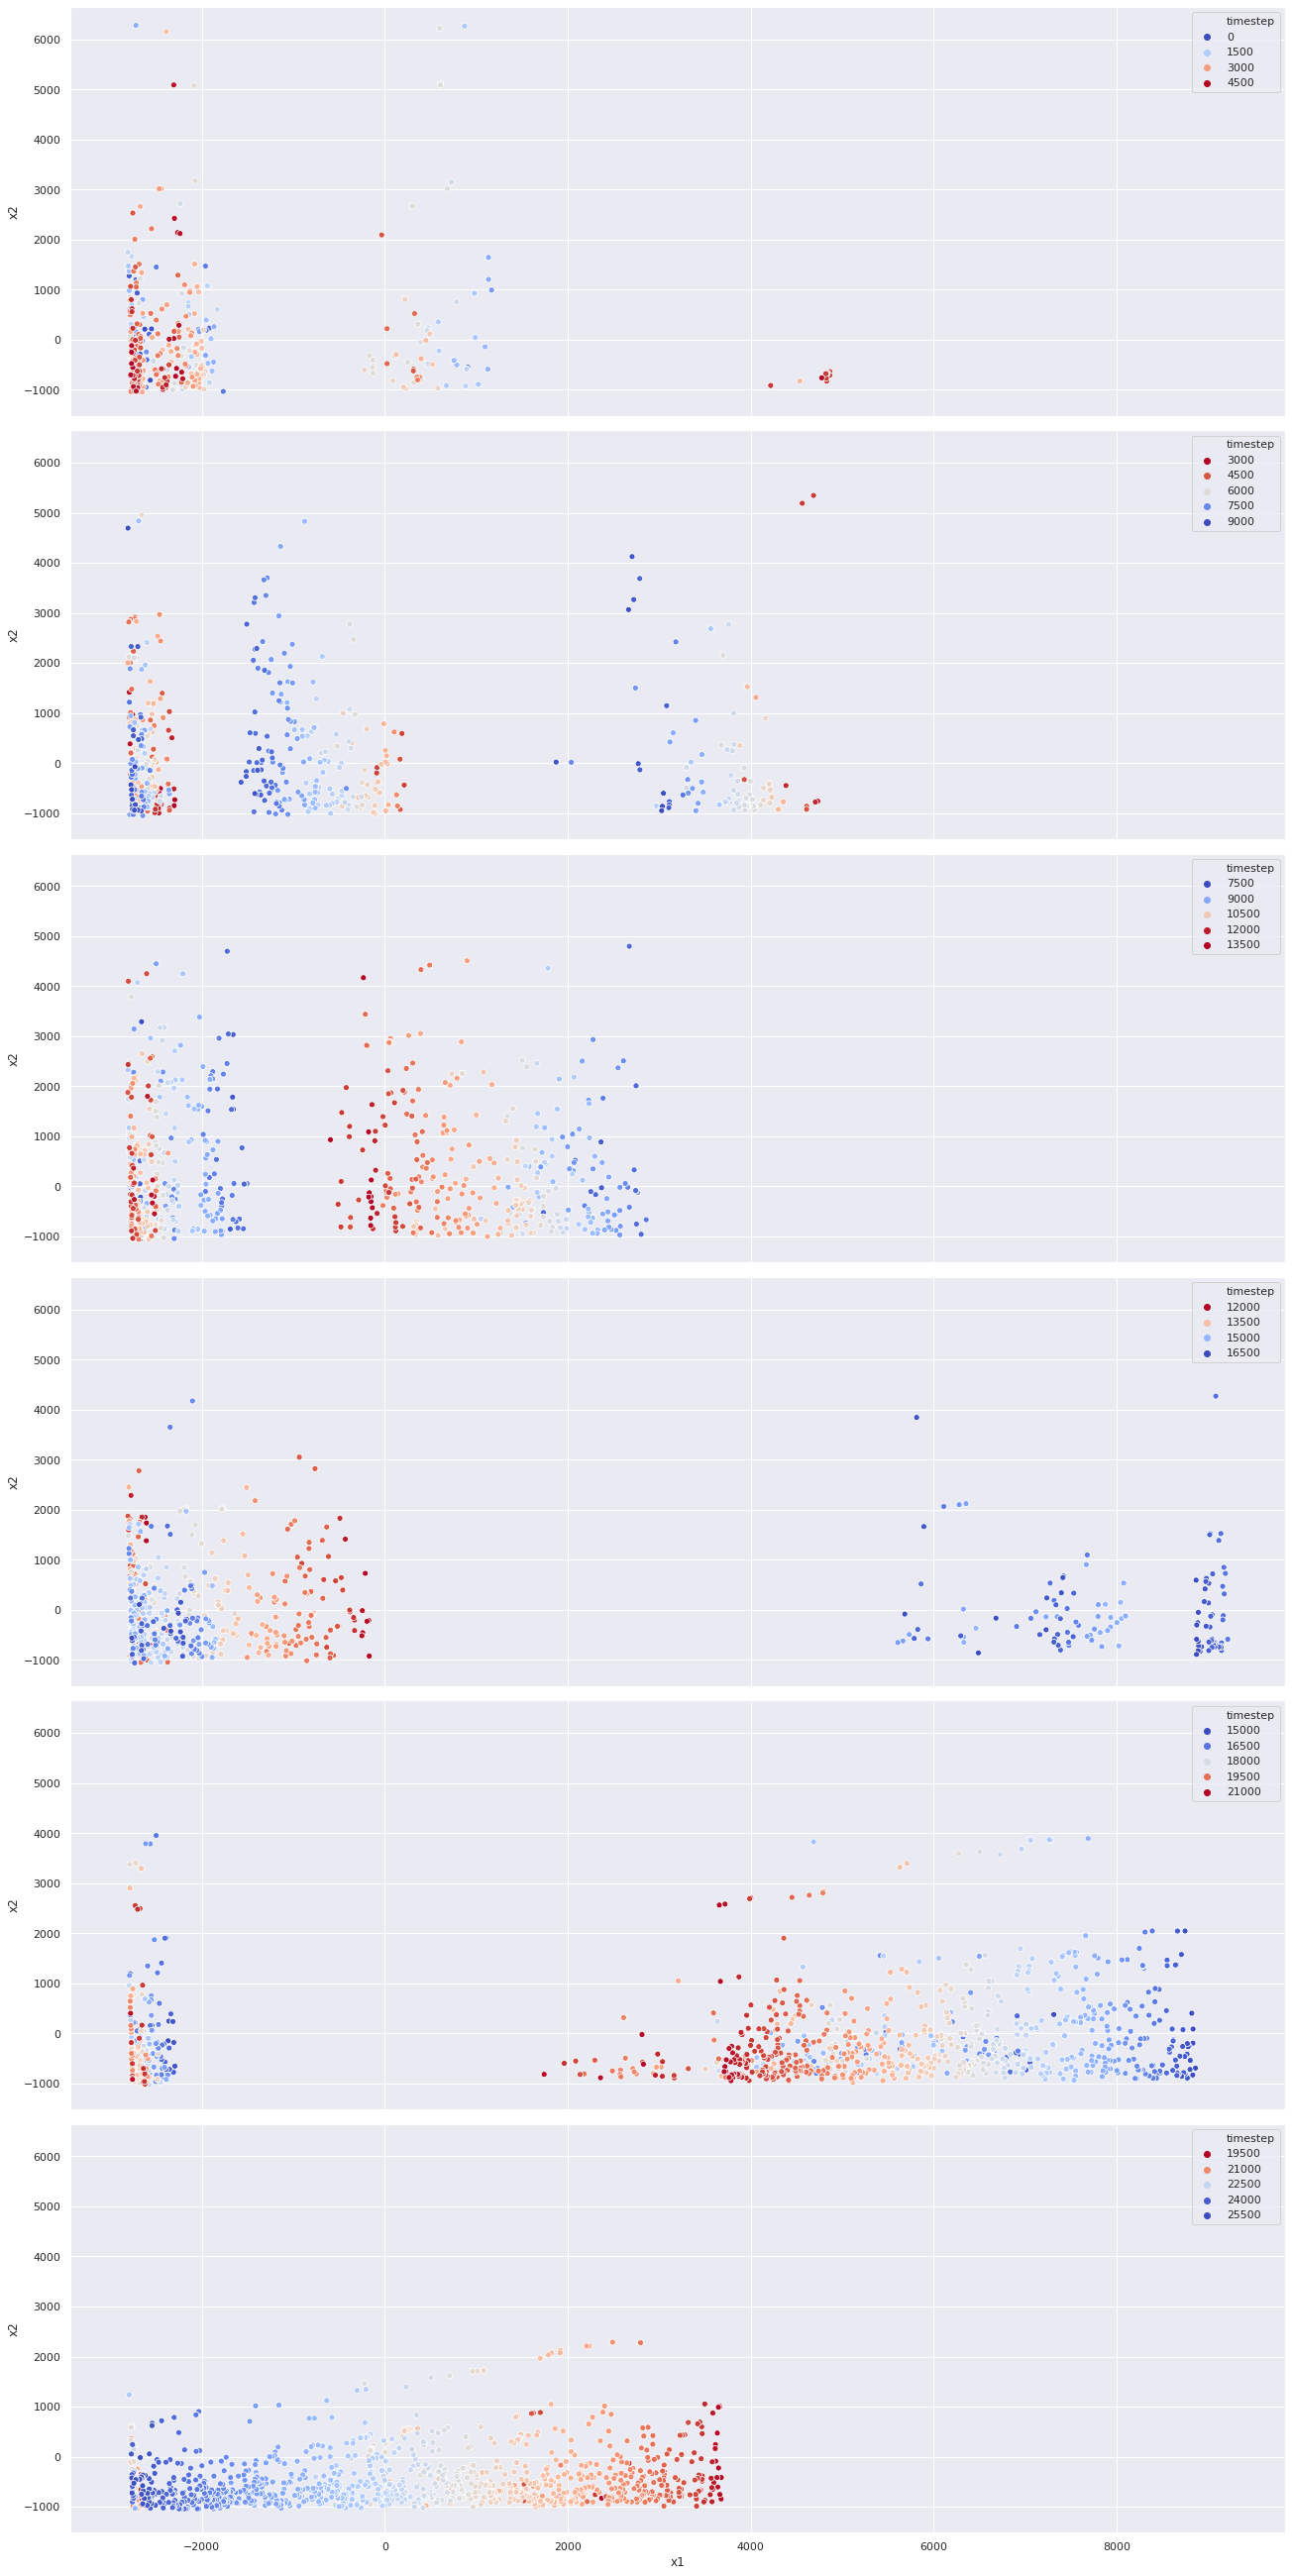

In [12]:
pts_bug = bug(pts)
plot_drift(pts_bug)